In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import drive, files # google colab specific
import requests
import pandas as pd
import os
import warnings
import sys
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from keras import layers
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# Read in the csv file that contains the time series data of the Shiller Index
# Create the dataframe

# Quarterly Data

#df = pd.read_csv('/content/ATNHPIUS45300Q (1).csv')
#df.head()

,DATE,ATNHPIUS45300Q
0,2002-01-01,151.34
1,2002-04-01,155.46
2,2002-07-01,159.55
3,2002-10-01,162.39
4,2003-01-01,165.24


In [103]:
filePath = "/content/drive/MyDrive/JPM/jphomevalue/data/ATNHPIUS45300Q.csv"
df = pd.read_csv(filePath, header = 0)
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df.index = df.index.to_period("1M")
df = df.resample('1M').interpolate()

In [45]:
df.to_csv('StPete-Clearwater.csv')
files.download('StPete-Clearwater.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [104]:
# Reset the index based on the prices
df1 = df.reset_index()['ATNHPIUS45300Q']
df1

0      151.340000
1      152.713333
2      154.086667
3      155.460000
4      156.823333
          ...    
233    394.440000
234    403.850000
235    411.443333
236    419.036667
237    426.630000
Name: ATNHPIUS45300Q, Length: 238, dtype: float64

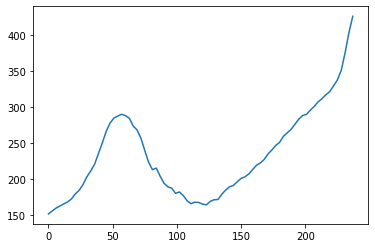

In [5]:
# Visualize the data for reference. 
plt.plot(df1)

In [ ]:
# Normalize the data with the range 0 - 1
scaler = MinMaxScaler(feature_range=(0,1))

# Apply the scaler to the dataframe
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

# Print df1 to check the change
print(df1)

In [107]:
# Split data into train, validation and test set. Ratio: 6/1/3
training_size = int(len(df1)*0.4)
validation_size = int(len(df1)*0.82) 
test_size = int(len(df1))

train_set = df1[0:training_size,:]
validation_set = df1[training_size:validation_size,:]
test_set = df1[validation_size:test_size,:1]

prediction_set = df1[71:238,:]

In [51]:
#prediction_set.shape
scaler.inverse_transform(prediction_set)

array([[190.35666667],
       [190.99      ],
       [192.70666667],
       [194.42333333],
       [196.14      ],
       [197.68      ],
       [199.22      ],
       [200.76      ],
       [201.48666667],
       [202.21333333],
       [202.94      ],
       [204.28666667],
       [205.63333333],
       [206.98      ],
       [209.05333333],
       [211.12666667],
       [213.2       ],
       [215.17666667],
       [217.15333333],
       [219.13      ],
       [220.17333333],
       [221.21666667],
       [222.26      ],
       [223.88666667],
       [225.51333333],
       [227.14      ],
       [229.70333333],
       [232.26666667],
       [234.83      ],
       [236.69      ],
       [238.55      ],
       [240.41      ],
       [242.51      ],
       [244.61      ],
       [246.71      ],
       [248.11      ],
       [249.51      ],
       [250.91      ],
       [253.77      ],
       [256.63      ],
       [259.49      ],
       [261.06333333],
       [262.63666667],
       [264

In [108]:
# Check sizes and set sizes
#training_size
#validation_size 
#test_size
print(train_set.shape)
print(validation_set.shape)
print(test_set.shape)

(95, 1)
(100, 1)
(43, 1)


In [109]:
# The current array of values needs to be converted into a dataset matrix
def create_dmatrix(dataset, time_step=1):
  data_X, data_Y = [], []
  for i in range(len(dataset)-time_step-1):
    k = dataset[i:(i + time_step), 0]
    data_X.append(k)
    data_Y.append(dataset[i + time_step, 0])
  return np.array(data_X), np.array(data_Y)

In [110]:
# Using the function already created for the conversion, convert training, validation and test sets. 
time_step = 24
X_train, Y_train = create_dmatrix(train_set, time_step)
X_val, Y_val = create_dmatrix(validation_set, time_step)
X_test, Y_test = create_dmatrix(test_set, time_step)
X_pred, Y_pred = create_dmatrix(prediction_set, time_step)

print('X Train set shape:', X_train.shape)
print('y Train set shape:', Y_train.shape)

print('X Validation set shape:', X_val.shape)
print('y Validation set shape:', Y_val.shape)

print('X Test set shape:', X_test.shape)
print('y Test set shape:', Y_test.shape)

print('X Pred set shape:', X_pred.shape)
print('y Pred set shape:', Y_pred.shape)


X Train set shape: (70, 24)
y Train set shape: (70,)
X Validation set shape: (75, 24)
y Validation set shape: (75,)
X Test set shape: (18, 24)
y Test set shape: (18,)
X Pred set shape: (142, 24)
y Pred set shape: (142,)


In [ ]:
# Check the matrixes created
X_test

In [112]:
# In order to feed the dataset to the neural network the data must be in 3D

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

In [113]:
# Hyperparameters
batch_size = 32
epochs = 200
learning_rate = 0.001

In [114]:
# LSTM MODEL ARCHITECTURE

model = keras.models.Sequential([
  keras.Input(shape=(24, 1)),
  # Masking layer, to ignore zeros.
  # keras.layers.Masking(),
  # 4 LSTM Layers with 16 units.
  keras.layers.LSTM(units=200, return_sequences=True),
  keras.layers.LSTM(units=200, return_sequences=True),
  keras.layers.LSTM(units=200, return_sequences=True),
  keras.layers.LSTM(units=200),
  keras.layers.Dropout(0.5),
  # Fully Connected Layer
  keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 200)           161600    
                                                                 
 lstm_5 (LSTM)               (None, 24, 200)           320800    
                                                                 
 lstm_6 (LSTM)               (None, 24, 200)           320800    
                                                                 
 lstm_7 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,124,201
Trainable params: 1,124,201
No

In [115]:
# Loss and Optimizer Functions
mse = tf.keras.losses.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()
model.compile(loss=mse, optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[rmse])

In [116]:
# Callbacks.

callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1), 
            ModelCheckpoint(filepath='/content/sample_data/lstm-model-st.pete-24-0.4-1.h5', verbose=1, monitor='val_loss', save_best_only=True, save_weights_only=False)]

# Train the model
history = model.fit(x=X_train, y=Y_train, validation_data =(X_val, Y_val), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=callbacks)

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.0899 - root_mean_squared_error: 0.2998
Epoch 1: val_loss improved from inf to 0.10788, saving model to /content/sample_data/lstm-model-st.pete-24-0.4-1.h5
3/3 [==============================] - 7s 830ms/step - loss: 0.0899 - root_mean_squared_error: 0.2998 - val_loss: 0.1079 - val_root_mean_squared_error: 0.3284
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1592 - root_mean_squared_error: 0.3990
Epoch 2: val_loss improved from 0.10788 to 0.02418, saving model to /content/sample_data/lstm-model-st.pete-24-0.4-1.h5
3/3 [==============================] - 1s 204ms/step - loss: 0.1592 - root_mean_squared_error: 0.3990 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1555
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.0559 - root_mean_squared_error: 0.2364
Epoch 3: val_loss did not improve from 0.02418
3/3 [==============================] - 0s 177ms/step - loss: 0.0559 - root_

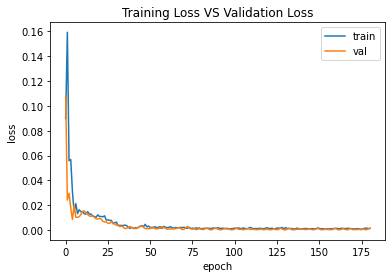

In [117]:
# Visualize loss

# Visualize training and validation loss.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss VS Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [28]:
model = keras.models.load_model('/content/lstm-model-st.pete-24-1.h5')

In [125]:
# Model evaluation
test_predicted = model.predict(X_pred)

In [126]:
test_predicted

array([[0.17531219],
       [0.17067975],
       [0.16559586],
       [0.16042817],
       [0.15545595],
       [0.1507828 ],
       [0.14651692],
       [0.14282086],
       [0.13991994],
       [0.13798165],
       [0.13693044],
       [0.13654913],
       [0.13657257],
       [0.13643444],
       [0.1355775 ],
       [0.13346139],
       [0.12998334],
       [0.12520283],
       [0.11942362],
       [0.1131153 ],
       [0.10686171],
       [0.10128058],
       [0.09677786],
       [0.09361032],
       [0.09187451],
       [0.09141094],
       [0.09192013],
       [0.0929762 ],
       [0.09428416],
       [0.0955893 ],
       [0.09692411],
       [0.09827273],
       [0.09977301],
       [0.10151041],
       [0.10371961],
       [0.10655538],
       [0.11000774],
       [0.11399961],
       [0.11835282],
       [0.1230029 ],
       [0.1279229 ],
       [0.13320944],
       [0.13909847],
       [0.1456666 ],
       [0.15295412],
       [0.16089204],
       [0.1693832 ],
       [0.178

In [128]:
# Apply inverse transformation
test_predicted= scaler.inverse_transform(test_predicted)
#Y_test = scaler.inverse_transform(Y_test)
#test_predicted = test_predicted.reshape(test_predicted.shape[0],test_predicted.shape[1])
#test_predicted.shape

In [129]:
#Y_test.shape
#test_predicted.shape
#test_predicted = test_predicted.reshape(test_predicted.shape[0])
test_predicted

array([[199.6017 ],
       [198.32643],
       [196.9269 ],
       [195.50427],
       [194.13547],
       [192.849  ],
       [191.67464],
       [190.65717],
       [189.85855],
       [189.32497],
       [189.03558],
       [188.9306 ],
       [188.93707],
       [188.89903],
       [188.66313],
       [188.0806 ],
       [187.12312],
       [185.80708],
       [184.21613],
       [182.4795 ],
       [180.75795],
       [179.22153],
       [177.98198],
       [177.10999],
       [176.63214],
       [176.50452],
       [176.64468],
       [176.93542],
       [177.29549],
       [177.65477],
       [178.02223],
       [178.3935 ],
       [178.80652],
       [179.28479],
       [179.89297],
       [180.67363],
       [181.62404],
       [182.72295],
       [183.92134],
       [185.20146],
       [186.5559 ],
       [188.01123],
       [189.63242],
       [191.44055],
       [193.44673],
       [195.63197],
       [197.96951],
       [200.41267],
       [202.8827 ],
       [205.29823],


In [ ]:
# Re-populate Y_test
#X_test, Y_test = create_dmatrix(test_set, time_step)
#Y_test = Y_test.reshape(test_predicted.shape[0],1)
#Y_test = scaler.inverse_transform(Y_test)
#Y_test = Y_test.reshape(-1)
Y_test

array([321.58      , 324.19      , 326.8       , 329.41      ,
       332.29      , 335.17      , 338.05      , 342.43666667,
       346.82333333, 351.21      , 359.34666667, 367.48333333,
       375.62      , 385.03      , 394.44      , 403.85      ,
       411.44333333, 419.03666667])

In [95]:
# Reshape Y_test to 2D
Y_test = Y_test.reshape(test_predicted.shape[0],1)
Y_test = scaler.inverse_transform(Y_test)

# Reshape back to 1D
Y_test = Y_test.reshape(test_predicted.shape[0])
Y_test

ValueError: ignored

In [121]:
# Reshape Y_pred to 2D
Y_pred = Y_pred.reshape(test_predicted.shape[0],1)
Y_pred = scaler.inverse_transform(Y_pred)

# Reshape back to 1D
Y_pred = Y_pred.reshape(test_predicted.shape[0])
Y_pred

array([187.81333333, 187.16      , 184.77666667, 182.39333333,
       180.01      , 180.64666667, 181.28333333, 181.92      ,
       180.26333333, 178.60666667, 176.95      , 174.49333333,
       172.03666667, 169.58      , 168.26      , 166.94      ,
       165.62      , 166.28666667, 166.95333333, 167.62      ,
       167.53333333, 167.44666667, 167.36      , 166.55      ,
       165.74      , 164.93      , 164.61333333, 164.29666667,
       163.98      , 165.57      , 167.16      , 168.75      ,
       169.52      , 170.29      , 171.06      , 171.16333333,
       171.26666667, 171.37      , 173.82      , 176.27      ,
       178.72      , 180.66      , 182.6       , 184.54      ,
       186.05666667, 187.57333333, 189.09      , 189.72333333,
       190.35666667, 190.99      , 192.70666667, 194.42333333,
       196.14      , 197.68      , 199.22      , 200.76      ,
       201.48666667, 202.21333333, 202.94      , 204.28666667,
       205.63333333, 206.98      , 209.05333333, 211.12

In [124]:
# Calculate RMSE
math.sqrt(mean_squared_error(Y_pred,test_predicted))


24.950336344888946

In [123]:
print(test_predicted[141])
print(Y_pred[141])

[326.7527]
419.0366666666667


In [ ]:
#test_predicted = test_predicted.reshape(-1, 1)
#test_predicted
test_predicted

In [130]:
from numpy import savetxt
np.savetxt('test_predicted.txt', test_predicted, fmt='%s')
files.download('test_predicted.txt')

In [131]:
files.download('test_predicted.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
training_predicted = model.predict(X_train)
validation_predicted = model.predict(X_val)

In [ ]:
training_predicted = scaler.inverse_transform(training_predicted)
#training_predicted.shape
validation_predicted = scaler.inverse_transform(validation_predicted)
#validation_predicted.shape
print(scaler.inverse_transform(validation_set))

[[223.88666667]
 [225.51333333]
 [227.14      ]
 [229.70333333]
 [232.26666667]
 [234.83      ]
 [236.69      ]
 [238.55      ]
 [240.41      ]
 [242.51      ]
 [244.61      ]
 [246.71      ]
 [248.11      ]
 [249.51      ]
 [250.91      ]
 [253.77      ]
 [256.63      ]
 [259.49      ]
 [261.06333333]
 [262.63666667]
 [264.21      ]
 [265.84      ]
 [267.47      ]
 [269.1       ]
 [271.56      ]
 [274.02      ]
 [276.48      ]
 [278.81333333]
 [281.14666667]]


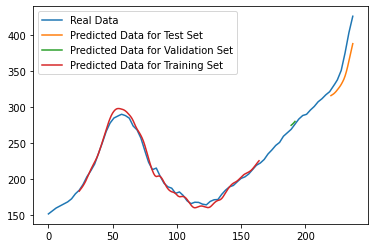

In [ ]:
# Plotting everything together
# Setting the intervals 

# shift training predictions for plotting
training_predicted_plot = np.empty_like(df1)
training_predicted_plot[:, :] = np.nan
#training_predicted.shape
#training_predicted_plot[14:167, :] = training_predicted
training_predicted_plot[24:165, :] = training_predicted

#training_predicted_plot[24:143, :] = training_predicted
# shift validation predictions for plotting
val_predicted_plot = np.empty_like(df1)
val_predicted_plot[:, :] = np.nan
#validation_predicted.shape
#val_predicted_plot[181:214, :] = validation_predicted
#val_predicted_plot[192:203, :] = validation_predicted
#val_predicted_plot[168:191, :] = validation_predicted
val_predicted_plot[189:193, :] = validation_predicted
# shift test predictions for plotting
test_predicted_plot = np.empty_like(df1)
test_predicted_plot[:, :] = np.nan
#test_predicted.shape
#test_predicted_plot[230:239, :] = test_predicted
#test_predicted_plot[228:239, :] = test_predicted
#test_predicted_plot[216:239, :] = test_predicted
test_predicted_plot[220:239, :] = test_predicted

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1), label = "Real Data")
plt.plot(test_predicted_plot, label = "Predicted Data for Test Set")
plt.plot(val_predicted_plot, label = "Predicted Data for Validation Set")
plt.plot(training_predicted_plot, label = "Predicted Data for Training Set")
plt.legend()
plt.show()

In [ ]:
#math.sqrt(mean_squared_error(Y_test,test_predicted))
#print(scaler.inverse_transform(train_set))
#print(scaler.inverse_transform(training_predicted))
#train_set_invers = scaler.inverse_transform(Y_train)
#math.sqrt(mean_squared_error(_test,test_predicted))
#Y_train_sh = Y_train.reshape(training_predicted.shape[0],1)
#train_set_invers = scaler.inverse_transform(Y_train_sh)

#Y_train_d = Y_train.reshape(-1, 1)
#train_set_invers = scaler.inverse_transform(Y_train_d)
#math.sqrt(mean_squared_error(train_set_invers, training_predicted))
#print(scaler.inverse_transform(X_test))
#test_predicted

array([[237.0811 ],
       [240.32011],
       [243.95862],
       [248.07315],
       [252.65337],
       [257.63763],
       [262.94397],
       [268.51364],
       [274.28806]], dtype=float32)

In [ ]:
# Create new array for future predictions

# Explanation. Since we have been predicting using timestep = 24, meaning we have used the past 24 prices to predict the 25th, now we will use the test_set data as that is the latest data to predict further INTO THE UNKNOWN!
# The size of the future_input array needs to be equal to timestep, so if you change the test_data size and timestep make sure to reflect those changes here as well.

pred_input=test_set[19:].reshape(1,-1)
pred_input

array([[0.58929371, 0.59589282, 0.60249192, 0.60779542, 0.61309891,
        0.61840241, 0.62788332, 0.63736423, 0.64684515, 0.65730684,
        0.66776853, 0.67823023, 0.69416494, 0.71009965, 0.72603436,
        0.75559107, 0.78514778, 0.81470449, 0.84888663, 0.88306876,
        0.9172509 , 0.94483393, 0.97241697, 1.        ]])

In [ ]:
# Add that to temp input
temp_input = []
temp_input=list(pred_input)
temp_input=temp_input[0].tolist()
temp_input 

[0.589293714507126,
 0.5958928160606392,
 0.6024919176141523,
 0.6077954157433978,
 0.6130989138726435,
 0.618402412001889,
 0.6278833230411567,
 0.6373642340804244,
 0.6468451451196922,
 0.6573068400595736,
 0.6677685349994553,
 0.6782302299393368,
 0.6941649412135082,
 0.7100996524876797,
 0.7260343637618512,
 0.7555910736556601,
 0.7851477835494691,
 0.8147044934432781,
 0.8488866286461552,
 0.883068763849032,
 0.917250899051909,
 0.9448339327012727,
 0.9724169663506366,
 1.0000000000000002]

In [ ]:
# Predict in the future

from numpy import array

list_output=[]
n_steps=24
i=0
while(i<12):
    
    if(len(temp_input)>24):
        print('Entering main condition')
        #print(temp_input)
        pred_input=np.array(temp_input[1:]) # Shift one to the right
        print("{} month input {}".format(i,pred_input))
        pred_input=pred_input.reshape(1,-1)
        pred_input = pred_input.reshape(1, n_steps, 1)
        print('Pred_input shape is:', pred_input.shape)
        fut_pred = model.predict(pred_input, verbose=0)
        print("{} month output {}".format(i,fut_pred))
        temp_input.extend(fut_pred[0].tolist()) # Add that prediction to the temp input list as that will be used in the next prediction 
        temp_input=temp_input[1:] #Shift the temp_input to remove the first element which was already used in a sequence
        #print(temp_input)
        list_output.extend(fut_pred.tolist())
        i=i+1
    else:
        print('Entering else condition')
        pred_input = pred_input.reshape((1, n_steps,1))
        fut_pred = model.predict(pred_input, verbose=0)
        print('The predicted value is:',fut_pred[0])
        temp_input.extend(fut_pred[0].tolist())
        print(len(temp_input))
        list_output.extend(fut_pred.tolist())
        i=i+1
    

print(list_output)

Entering else condition
The predicted value is: [0.905854]
25
Entering main condition
1 month input [0.59589282 0.60249192 0.60779542 0.61309891 0.61840241 0.62788332
 0.63736423 0.64684515 0.65730684 0.66776853 0.67823023 0.69416494
 0.71009965 0.72603436 0.75559107 0.78514778 0.81470449 0.84888663
 0.88306876 0.9172509  0.94483393 0.97241697 1.         0.90585399]
Pred_input shape is: (1, 24, 1)
1 month output [[0.8948424]]
Entering main condition
2 month input [0.60249192 0.60779542 0.61309891 0.61840241 0.62788332 0.63736423
 0.64684515 0.65730684 0.66776853 0.67823023 0.69416494 0.71009965
 0.72603436 0.75559107 0.78514778 0.81470449 0.84888663 0.88306876
 0.9172509  0.94483393 0.97241697 1.         0.90585399 0.89484239]
Pred_input shape is: (1, 24, 1)
2 month output [[0.8619143]]
Entering main condition
3 month input [0.60779542 0.61309891 0.61840241 0.62788332 0.63736423 0.64684515
 0.65730684 0.66776853 0.67823023 0.69416494 0.71009965 0.72603436
 0.75559107 0.78514778 0.81470

In [ ]:
month_new = np.arange(1, 24)
month_pred = np.arange(24,36)

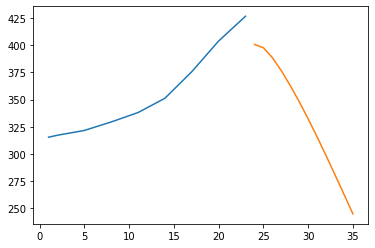

In [ ]:
plt.plot(month_new,scaler.inverse_transform(df1[215:]))
plt.plot(month_pred,scaler.inverse_transform(list_output))

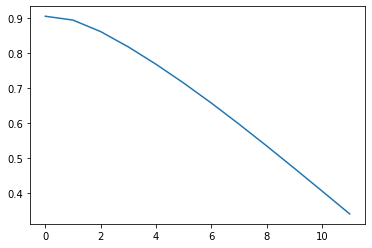

In [ ]:
df3 = df1.tolist()
df3.extend(list_output)
plt.plot(df3[238:])

In [ ]:
print(scaler.inverse_transform(list_output))

[[400.71254401]
 [397.68116051]
 [388.61638134]
 [376.54860548]
 [362.88076504]
 [348.05904166]
 [332.26780194]
 [315.66814516]
 [298.45306883]
 [280.8097208 ]
 [262.89438445]
 [244.82475017]]


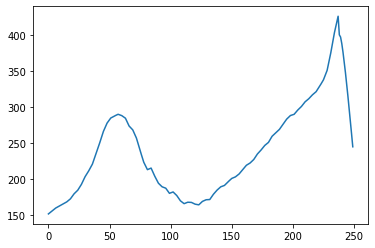

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)

In [ ]:
# Make copy of original data
df_orig33 = pd.read_csv('/content/Model_Tampa_Prediction_6months.csv')
df_orig33

,DATE,TPXRSA
0,2002-01-01,120.395793
1,2002-02-01,120.700034
2,2002-03-01,122.958147
3,2002-04-01,123.707047
4,2002-05-01,124.950321
...,...,...
241,2022-02-01,295.493895
242,2022-03-01,285.777483
243,2022-04-01,272.348633
244,2022-05-01,257.288102


In [ ]:
output1_df = pd.DataFrame(df3, columns=['Sale Price'])
output1_df

,Sale Price
0,151.340000
1,152.713333
2,154.086667
3,155.460000
4,156.823333
...,...
245,315.668145
246,298.453069
247,280.809721
248,262.894384


In [ ]:
test_df = df_orig.copy()
test_df['TXP'] = output1_df

In [ ]:
result = [output1_df, df_orig]
new_df = pd.concat(result, axis =1)

In [ ]:
new_df = new_df.drop(['TPXRSA'], axis =1 )

In [ ]:
new_df

,Sale Price,DATE
0,120.395793,2002-01-01
1,120.700034,2002-02-01
2,122.958147,2002-03-01
3,123.707047,2002-04-01
4,124.950321,2002-05-01
...,...,...
241,295.493895,NaN
242,285.777483,NaN
243,272.348633,NaN
244,257.288102,NaN


In [ ]:
#new_df['DATE'] = pd.to_datetime(new_df['DATE'])
#new_df = new_df.set_index('DATE')
#new_df.index = new_df.index.to_period("1M")


In [ ]:
#new_df = new_df.drop(['TPXRSA'], axis =1 )

In [ ]:
#new_date_range = pd.date_range(start="2002-01", end='2023-01', freq="M")
#new_date_range = pd.Series(pd.date_range("1/1/2002", freq="M", periods=len(df3)))
#new_df = new_df.reindex(new_date_range, fill_value=0)

In [ ]:
#new_df['Sale Price'] = output1_df['Sale Price']

#new_df = new_df.append(output1_df, ignore_index = True)

In [ ]:
#df_orig1 = df_orig.copy()



TypeError: ignored

In [ ]:
result1 = [new_df, output_df]
new_df = pd.concat(result1, axis =1)


In [ ]:
df.to_csv('Model_Prediction_StPete_12months.csv')
files.download('Model_Prediction_StPete_12months.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>